In [1]:
!pip3 uninstall statsmodels

Found existing installation: statsmodels 0.12.2
Uninstalling statsmodels-0.12.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/statsmodels-0.12.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/statsmodels/*
Proceed (y/n)? y
  Successfully uninstalled statsmodels-0.12.2


In [2]:
!pip3 install numpy scipy patsy pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip3 install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 8.6 MB/s 


In [4]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 7.5 MB/s 


In [57]:
import pandas as pd
import zipfile
import glob
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import pacf

## Step 1: Read multiple csv files zipped in one file and concatenate them.

In [105]:
#Read the zip file that contains multiple csv file
from zipfile import ZipFile
from google.colab import files
!wget 'https://raw.githubusercontent.com/Myloveismilk/vn_stock_price/main/data/archive.zip'
url = '/content/archive.zip'
df = pd.concat(
    [pd.read_csv(ZipFile(url).open(i)) for i in ZipFile(url).namelist()],
    ignore_index=True
)

--2022-10-27 11:00:31--  https://raw.githubusercontent.com/Myloveismilk/vn_stock_price/main/data/archive.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3066402 (2.9M) [application/zip]
Saving to: ‘archive.zip.5’

archive.zip.5       100%[===================>]   2.92M  --.-KB/s    in 0.06s   

2022-10-27 11:00:32 (47.1 MB/s) - ‘archive.zip.5’ saved [3066402/3066402]



In [106]:
#See the first 5 rows of the dataset
df.head()

,Open Time,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,TB Base Volume,TB Quote Volume,Ignore
0,2019-07-30 00:00:00.000000000,9509.07,9535.00,9503.07,9517.75,381.293856,2019-07-30 00:29:59.999000064,3.631211e+06,3492,216.528742,2.062189e+06,0
1,2019-07-30 00:30:00.000000000,9517.03,9539.00,9507.00,9532.58,258.514869,2019-07-30 00:59:59.999000064,2.462134e+06,3133,141.887550,1.351182e+06,0
2,2019-07-30 01:00:00.000000000,9533.59,9534.00,9500.00,9500.25,275.797270,2019-07-30 01:29:59.999000064,2.624322e+06,3583,114.238457,1.087402e+06,0
3,2019-07-30 01:30:00.000000000,9500.25,9514.46,9460.71,9465.25,485.218470,2019-07-30 01:59:59.999000064,4.604004e+06,5330,225.681291,2.141459e+06,0
4,2019-07-30 02:00:00.000000000,9465.25,9488.94,9430.01,9460.42,498.669626,2019-07-30 02:29:59.999000064,4.717269e+06,6197,228.535910,2.162163e+06,0


## Step 2: Drop, rename some columns and format their types.

In [107]:
df.columns

Index(['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time',
       'Quote Asset Volume', 'Number of Trades', 'TB Base Volume',
       'TB Quote Volume', 'Ignore'],
      dtype='object')

In [108]:
#Some columns isn't necessary for predicting the bitcoin price, so let's remove it.
df = df.drop(columns= ['Close Time','Quote Asset Volume', 'Number of Trades', 'TB Base Volume','TB Quote Volume', 'Ignore'])

In [109]:
df.columns

Index(['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [110]:
#The names of all columns seem to be not in the right format, so let's change them
df = df.rename(columns= {'Open Time':'Date'})

In [111]:
df.head()

,Date,Open,High,Low,Close,Volume
0,2019-07-30 00:00:00.000000000,9509.07,9535.00,9503.07,9517.75,381.293856
1,2019-07-30 00:30:00.000000000,9517.03,9539.00,9507.00,9532.58,258.514869
2,2019-07-30 01:00:00.000000000,9533.59,9534.00,9500.00,9500.25,275.797270
3,2019-07-30 01:30:00.000000000,9500.25,9514.46,9460.71,9465.25,485.218470
4,2019-07-30 02:00:00.000000000,9465.25,9488.94,9430.01,9460.42,498.669626


In [112]:
#Let's look at the type of each column
df['Date'] = df['Date'].astype('string')
df.dtypes

Date       string
Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object

In [113]:
#We don't need a specific time in our dataset, just need the date
def remove_time(column):
  temp = 0
  for i in range(len(column)):
    column[i] = column[i][0: 10]
    if temp <= 10:
      print(column[i])
      temp += 1

In [114]:
remove_time(df['Date'])

2019-07-30
2019-07-30
2019-07-30
2019-07-30
2019-07-30
2019-07-30
2019-07-30
2019-07-30
2019-07-30
2019-07-30
2019-07-30


In [115]:
#Keep only this year values, drop the redundant.
remove_part = df[df['Date'].str[3] != '2']
df = df.drop(remove_part.index, axis = 0)

In [116]:
#Change date type to datetime64
df['Date'] = df['Date'].astype('datetime64')

In [117]:
# We see that there many redundant dates so we need to delele them, just keep the final price of the day.
df = df.drop_duplicates('Date',keep='last')
df.set_index('Date', inplace= True)

In [118]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2022-01-01,47428.91,47814.00,47370.58,47722.65,516.06976
2022-01-02,47394.62,47469.34,47283.71,47286.18,305.23928
2022-01-03,46409.99,46576.94,46365.87,46446.10,453.37383
2022-01-04,46039.99,46040.40,45760.05,45832.01,476.17284
2022-01-05,43636.28,43670.00,43400.00,43451.13,1214.89054


In [119]:
from pmdarima.model_selection import train_test_split

train_data, test_data = train_test_split(df['Close'], test_size = 10)
test_data.shape, train_data.shape

((10,), (260,))

## Step 3: Handle Missings

In [120]:
df.shape

(270, 5)

In [121]:
df.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [122]:
#The dataset look fine now, let's save it for future work.
df.to_csv('bitcoin_price.csv')

## Step 4: Quick visualization

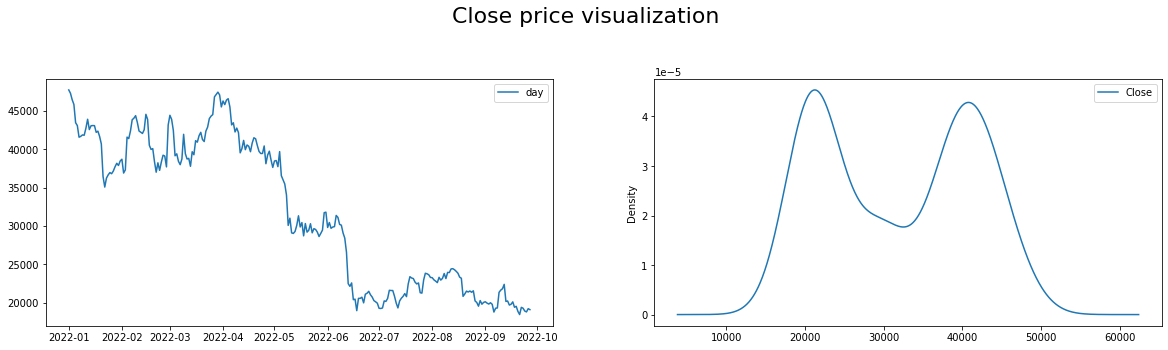

In [123]:
fig = plt.figure(figsize=[20, 10]);
plt.suptitle('Close price visualization', fontsize=22)

plt.subplot(221)
plt.plot(df['Close'], '-', label= 'day');
plt.legend();

plt.subplot(222)
df['Close'].plot(kind = 'kde');
plt.legend();

In [124]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['Close'], model='multiplicative', period = 3)

<Figure size 432x288 with 0 Axes>

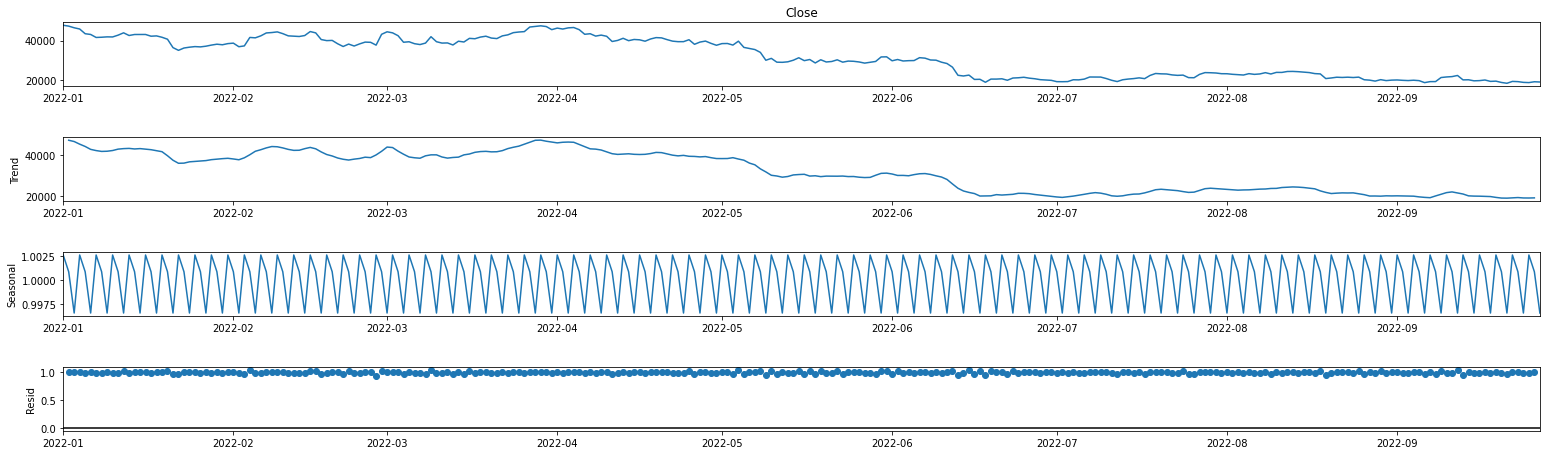

In [125]:
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(25, 7)

## Step 5: Stationarity test

In [126]:
from statsmodels.tsa.stattools import adfuller

In [127]:
# H0 : It is not stationary
# H1 : It is stationary
def adfuller_test(close_price):
  test_result = adfuller(close_price)
  labels = ['Test Statistic', 'p_value', 'Lag', 'Number of observations']
  for result, label in zip(test_result, labels):
    print(label + ' : ' + str(result))
  for key,value in test_result[4].items():
    print(f"critical value {key} :=  {value}")
  
adfuller_test(df['Close'])

Test Statistic : -1.2527763768457347
p_value : 0.650490985052325
Lag : 0
Number of observations : 269
critical value 1% :=  -3.4548957220044336
critical value 5% :=  -2.8723451788613157
critical value 10% :=  -2.572527778361272


We can see that the p_value is much greater than 0.05 and also the test statistic is greater than all critical values so the data is non-stationary.

In [128]:
df['seasonal_first_difference'] = df['Close'] - df['Close'].shift(1)
df['seasonal_first_difference'][0:5]

Date
2022-01-01        NaN
2022-01-02    -436.47
2022-01-03    -840.08
2022-01-04    -614.09
2022-01-05   -2380.88
Name: seasonal_first_difference, dtype: float64

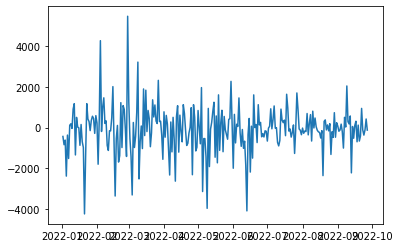

In [129]:
plt.plot(df['seasonal_first_difference'])

In [130]:
# Lets see the adf test result after differencing.
adfuller_test(df['seasonal_first_difference'].dropna())

Test Statistic : -16.363218547234357
p_value : 2.8571941703026916e-29
Lag : 0
Number of observations : 268
critical value 1% :=  -3.454988209954765
critical value 5% :=  -2.8723857312734613
critical value 10% :=  -2.572549407997327


The p_value is now less than 0.05 so we can reject the NULL hypothesis and the data is now stationary

##Step 6: Identifying the order of AR and MA terms

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


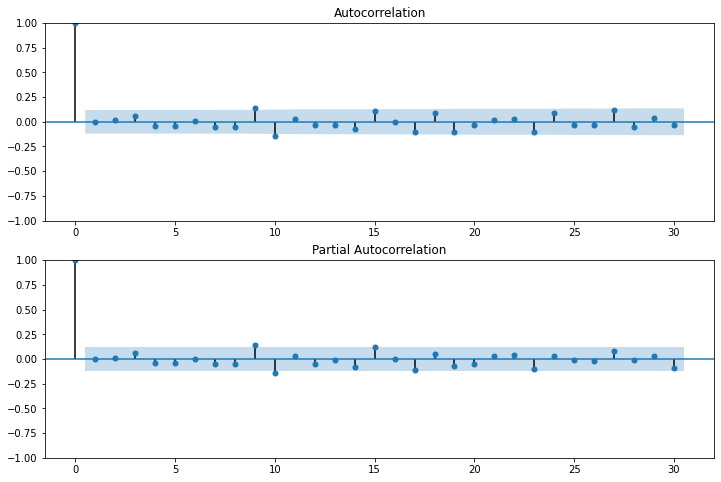

In [131]:
#Plot PACF & ACF chart
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['seasonal_first_difference'].dropna(),lags=30,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['seasonal_first_difference'].dropna(),lags=30,ax=ax2)

So we can see here the p = 2, d = 2, q = 6, let's move on to build the model.

##Step 7: Modeling

In [132]:
from pmdarima.arima import auto_arima

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=4312.539, Time=2.33 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4369.364, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4335.345, Time=0.32 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4324.372, Time=0.33 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=4372.719, Time=0.21 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=4306.910, Time=2.51 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=4337.267, Time=0.62 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=inf, Time=6.57 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=6.64 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=4307.657, Time=4.99 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=4327.581, Time=1.66 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=inf, Time=6.91 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=4305.814, Time=2.08 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=4335.707, Time=0.26 sec
 ARIMA(0,1,1)(2,1,1)[12]          

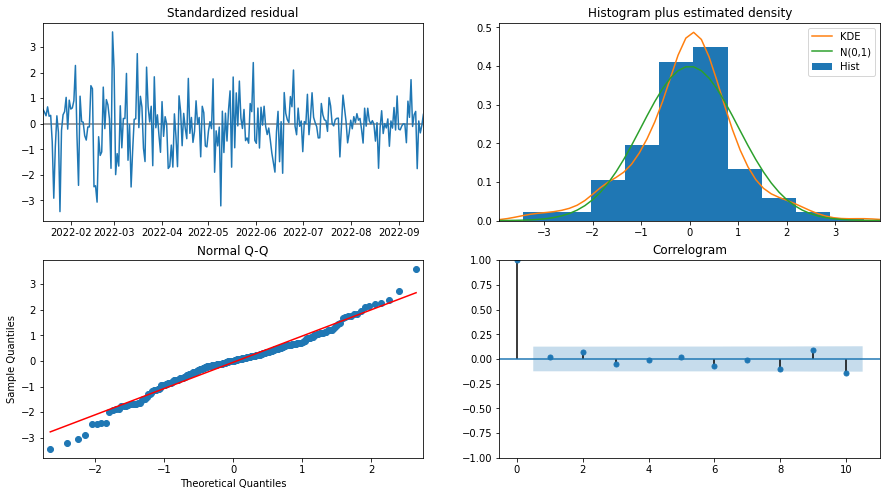

In [133]:
arima_model = auto_arima(train_data, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True) 
print(arima_model.summary())
arima_model.plot_diagnostics(figsize=(15,8))
plt.show()

In [134]:
import statsmodels.api as sa

In [135]:
model=sa.tsa.statespace.SARIMAX(train_data,order=(0, 1, 1),seasonal_order=(2,1,0,12))
results=model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [136]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Close   No. Observations:                  260
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood               -2153.856
Date:                             Thu, 27 Oct 2022   AIC                           4315.712
Time:                                     11:02:15   BIC                           4329.750
Sample:                                 01-01-2022   HQIC                          4321.364
                                      - 09-17-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0125      0.052     -0.239      0.811      -0.115       0.090
ar.S.L12      -0.3659      0.016    -22.299      0.000      -0.398      -0.334
ar.S.L24      -0.1572      0.018     -8.684      0.000      -0.193      -0.122
sigma2       2.05e+06   1.47e+05     13.964      0.000    1.76e+06    2.34e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                37.86
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2292: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


Date
2022-09-19    19538.382894
2022-09-20    19479.931562
2022-09-21    20635.490899
2022-09-22    20890.123221
2022-09-23    20880.608285
2022-09-24    20920.616462
2022-09-25    19576.482906
2022-09-26    19631.738022
2022-09-27    19255.688840
Name: forecast, dtype: float64

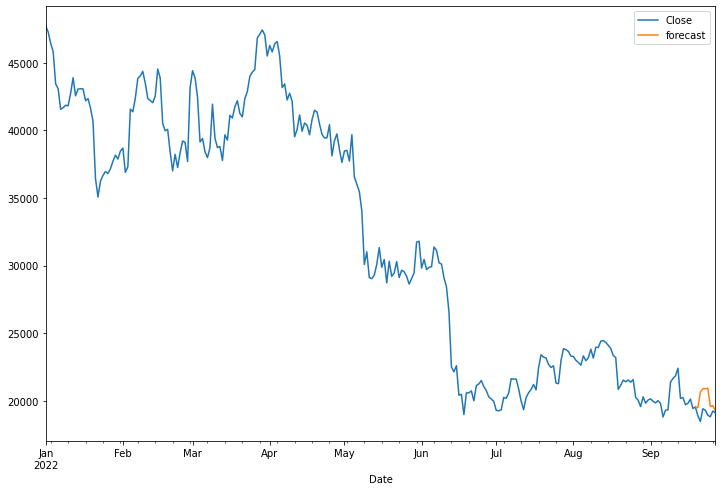

In [138]:
df['forecast']=results.predict(start = 261, end = 270, dynamic = True)
df[['Close','forecast']].plot(figsize=(12,8))
df['forecast'].dropna()[0:10]